In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 05:23:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('dataset1-1/part-00000-08c7db4a-479f-4c60-9ae4-4ae109f8ec54-c000.csv', header=True)
df.describe().show()

+-------+-----------+------+---------------------+---------------------+--------------------+-----------+------------------+
|summary|    Country|Gender|Demographics Question|Demographics Response|            Question|Survey Year|             Value|
+-------+-----------+------+---------------------+---------------------+--------------------+-----------+------------------+
|  count|      11187| 11187|                11187|                11187|               11187|      11187|             11187|
|   mean|       null|  null|                 null|                 null|                null|       null| 4.005106687322341|
| stddev|       null|  null|                 null|                 null|                null|       null|1.9292459669184192|
|    min|Afghanistan|     F|                  Age|                15-24|... for at least ...| 01/01/2000|               0.0|
|    max|   Zimbabwe|     M|            Residence| Widowed, divorced...|... if she refuse...| 01/01/2018| 9.322017030979879|


In [9]:
!pip install scikit-learn
from pyspark.sql.functions import col
import seaborn as sns
from pyspark.sql.types import FloatType,IntegerType
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = df.withColumn("Value", col("Value").cast(FloatType()))
df1 = df.toPandas()

X_Country = pd.get_dummies(df1['Country'], drop_first=True, dtype=int)
X_Gender = pd.get_dummies(df1['Gender'], drop_first=True, dtype=int)
X_dq = pd.get_dummies(df1['Demographics Question'], drop_first=True, dtype=int)
X_dr = pd.get_dummies(df1['Demographics Response'], drop_first=True, dtype=int)
X_Question = pd.get_dummies(df1['Question'], drop_first=True, dtype=int)
X_sy = pd.get_dummies(df1['Survey Year'], drop_first=True, dtype=int)

df_encoded = pd.concat([df1, X_Country, X_Gender,X_dq,X_dr,X_Question,X_sy], axis=1)

df_encoded.drop(['Country', 'Gender','Demographics Question','Demographics Response','Question','Survey Year'], axis=1, inplace=True)

y = df_encoded['Value']

X = df_encoded.drop('Value', axis=1)
X = sm.add_constant(X)  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# MLPRegressor
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), 
                        validation_fraction=0.2, early_stopping=True,random_state=42)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)
nn_rmse = mean_squared_error(y_test, nn_predictions, squared=False)
print(nn_rmse)

Defaulting to user installation because normal site-packages is not writeable
0.30717768790220074


In [5]:
from sklearn.inspection import permutation_importance
import numpy as np

# Calculating feature importance
perm_importance = permutation_importance(nn_model, X_test, y_test, n_repeats=30, random_state=42)

# Get a ranking of feature importance
importance_ranking = np.argsort(perm_importance.importances_mean)[::-1]

# Print feature importance
for i, idx in enumerate(importance_ranking):
    print(f"Feature {X_test.columns[idx]} importance rank: {i + 1}")

Feature 01/01/2015 importance rank: 1
Feature ... if she burns the food importance rank: 2
Feature ... if she refuses to have sex with him importance rank: 3
Feature M importance rank: 4
Feature Colombia importance rank: 5
Feature ... if she argues with him importance rank: 6
Feature ... if she goes out without telling him importance rank: 7
Feature Mozambique importance rank: 8
Feature Armenia importance rank: 9
Feature Malawi importance rank: 10
Feature Higher importance rank: 11
Feature 01/01/2018 importance rank: 12
Feature Chad importance rank: 13
Feature Congo Democratic Republic importance rank: 14
Feature 01/01/2013 importance rank: 15
Feature Timor-Leste importance rank: 16
Feature ... if she neglects the children importance rank: 17
Feature Angola importance rank: 18
Feature Niger importance rank: 19
Feature Dominican Republic importance rank: 20
Feature No education importance rank: 21
Feature Tajikistan importance rank: 22
Feature 01/01/2014 importance rank: 23
Feature Kyrg

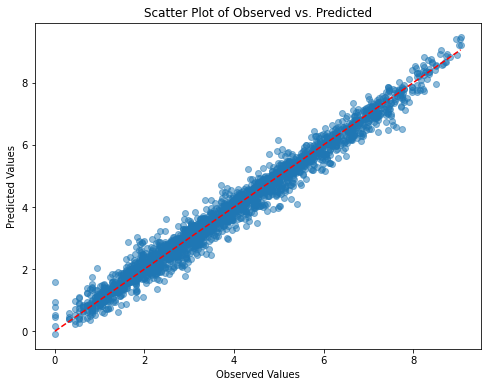

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, nn_predictions, alpha=0.5)
plt.title("Scatter Plot of Observed vs. Predicted")
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

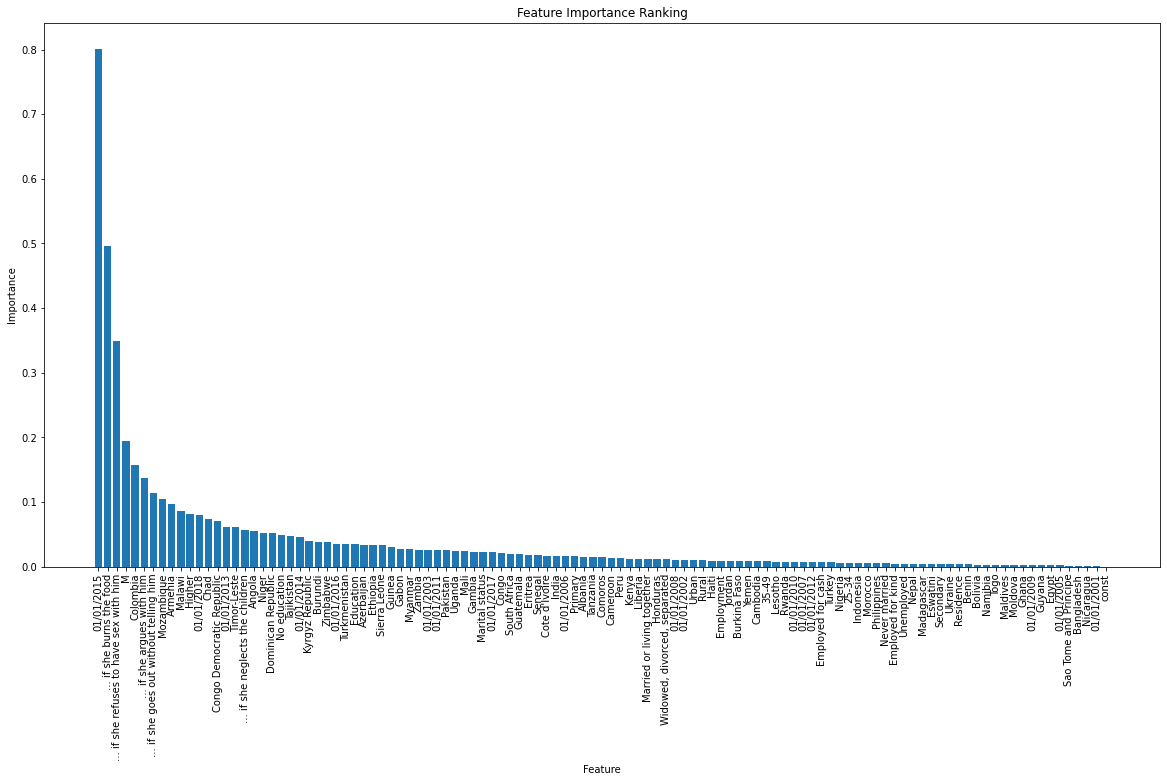

In [7]:
# The importance ranking of the features and the corresponding feature names are obtained
feature_names = [X_test.columns[idx] for idx in importance_ranking]
feature_importance = [perm_importance.importances_mean[idx] for idx in importance_ranking]


plt.figure(figsize=(20, 10))
plt.bar(range(len(feature_names)), feature_importance, tick_label=feature_names)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Ranking')
plt.xticks(rotation=90)  
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


train_predictions = nn_model.predict(X_train)
test_predictions = nn_model.predict(X_test)


train_min_error = np.min(np.abs(y_train - train_predictions))
train_max_error = np.max(np.abs(y_train - train_predictions))
train_avg_error = np.mean(y_train - train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_std_deviation = np.std(y_train - train_predictions)
train_correlation = np.corrcoef(y_train, train_predictions)[0, 1]


test_min_error = np.min(np.abs(y_test - test_predictions))
test_max_error = np.max(np.abs(y_test - test_predictions))
test_avg_error = np.mean(y_test - test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_std_deviation = np.std(y_test - test_predictions)
test_correlation = np.corrcoef(y_test, test_predictions)[0, 1]

# Print the results for the training set
print("Training Set Error Metrics:")
print(f"Minimum Error: {train_min_error}")
print(f"Maximum Error: {train_max_error}")
print(f"Average Error: {train_avg_error}")
print(f"Mean Absolute Error (MAE): {train_mae}")
print(f"Standard Deviation: {train_std_deviation}")
print(f"Linear Correlation: {train_correlation}")

# Print the results for the test set
print("\nTesting Set Error Metrics:")
print(f"Minimum Error: {test_min_error}")
print(f"Maximum Error: {test_max_error}")
print(f"Average Error: {test_avg_error}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"Standard Deviation: {test_std_deviation}")
print(f"Linear Correlation: {test_correlation}")


Training Set Error Metrics:
Minimum Error: 8.635619941799177e-06
Maximum Error: 2.3092709477375917
Average Error: 0.0036099354576280777
Mean Absolute Error (MAE): 0.08475492140040822
Standard Deviation: 0.14829203610482247
Linear Correlation: 0.9970161857589039

Testing Set Error Metrics:
Minimum Error: 0.00018157590739598106
Maximum Error: 1.6673678099892246
Average Error: -0.0040321205760521246
Mean Absolute Error (MAE): 0.21928995914801727
Standard Deviation: 0.2903438847425563
Linear Correlation: 0.9890962699005477
